# 1. Importing Libraries

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# 2. Reviewing the training dataset

In [30]:
train_df = pd.read_csv('train_file.csv')
train_df.head()

,id,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy,cltv
0,1,Male,Urban,Bachelor,5L-10L,1,5,5790,More than 1,A,Platinum,64308
1,2,Male,Rural,High School,5L-10L,0,8,5080,More than 1,A,Platinum,515400
2,3,Male,Urban,Bachelor,5L-10L,1,8,2599,More than 1,A,Platinum,64212
3,4,Female,Rural,High School,5L-10L,0,7,0,More than 1,A,Platinum,97920
4,5,Male,Urban,High School,More than 10L,1,6,3508,More than 1,A,Gold,59736


In [31]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89392 entries, 0 to 89391
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              89392 non-null  int64 
 1   gender          89392 non-null  object
 2   area            89392 non-null  object
 3   qualification   89392 non-null  object
 4   income          89392 non-null  object
 5   marital_status  89392 non-null  int64 
 6   vintage         89392 non-null  int64 
 7   claim_amount    89392 non-null  int64 
 8   num_policies    89392 non-null  object
 9   policy          89392 non-null  object
 10  type_of_policy  89392 non-null  object
 11  cltv            89392 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 8.2+ MB


### Encoding the categorical data

In [32]:
col_to_encode = ['gender', 'area', 'qualification', 'income', 'num_policies', 'policy', 'type_of_policy']

for col in col_to_encode:
    print(train_df[col].value_counts(), '\n')

Male      50497
Female    38895
Name: gender, dtype: int64 

Urban    62455
Rural    26937
Name: area, dtype: int64 

High School    46247
Bachelor       39399
Others          3746
Name: qualification, dtype: int64 

5L-10L           52716
2L-5L            21158
More than 10L    13664
<=2L              1854
Name: income, dtype: int64 

More than 1    60263
1              29129
Name: num_policies, dtype: int64 

A    56644
B    24635
C     8113
Name: policy, dtype: int64 

Platinum    47796
Silver      21010
Gold        20586
Name: type_of_policy, dtype: int64 



In [33]:
encoding_dict = {
    'gender_dict' : {'Male': 0, 'Female': 1}, 
    'area_dict' : {'Rural': 0, 'Urban': 1}, 
    'qualification_dict' : {'Others': 0, 'High School': 1, 'Bachelor': 2}, 
    'income_dict' : {'<=2L': 0, '2L-5L': 1, '5L-10L': 2, 'More than 10L': 3}, 
    'num_policies_dict' : {'1': 0, 'More than 1': 1}, 
    'policy_dict' : {'A': 0, 'B': 1, 'C': 2}, 
    'type_of_policy_dict' : {'Silver': 0, 'Gold': 1, 'Platinum': 2}
}

for col in col_to_encode:
    train_df[col] = train_df[col].map(encoding_dict[f'{col}_dict'])

<AxesSubplot:>

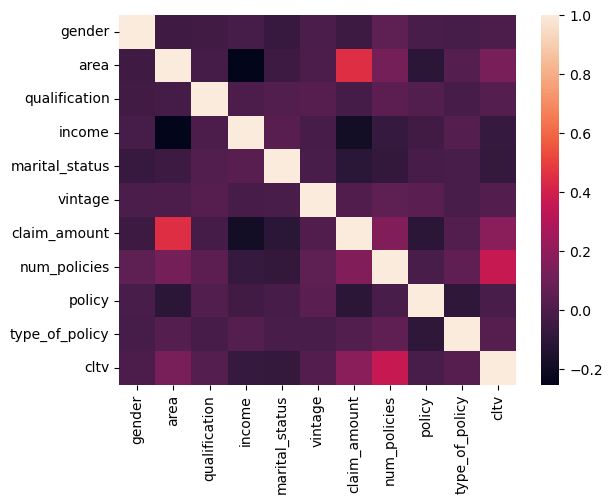

In [34]:
sns.heatmap(train_df.drop(['id'], axis=1).corr())

# 3. Preparing ML model

In [35]:
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

poly = PolynomialFeatures(degree=3, include_bias=False)

X = train_df.drop(['id', 'cltv'], axis=1)
y = train_df['cltv']

scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)
poly_features = poly.fit_transform(scaled_X)

lr = LinearRegression()

params_lr = {
    'n_jobs': [1, 2, 5, 10]
}
lr_gs = GridSearchCV(estimator=lr, param_grid=params_lr, scoring='r2', cv=8, n_jobs=-1, verbose=1)

lr_gs.fit(poly_features, y)

Fitting 8 folds for each of 4 candidates, totalling 32 fits


GridSearchCV(cv=8, estimator=LinearRegression(), n_jobs=-1,
             param_grid={'n_jobs': [1, 2, 5, 10]}, scoring='r2', verbose=1)

In [36]:
print(lr_gs.best_estimator_)
print(lr_gs.best_score_)

LinearRegression(n_jobs=1)
0.15845866555072277


# 4. Testing the model on the testing dataset and getting the predictions

In [37]:
test_df = pd.read_csv('test_file.csv')

for col in col_to_encode:
    test_df[col] = test_df[col].map(encoding_dict[f'{col}_dict'])
    
test_df.head()

,id,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy
0,89393,1,0,1,2,0,6,2134,1,1,0
1,89394,1,1,1,1,0,4,4102,1,0,2
2,89395,0,0,1,2,1,7,2925,1,1,1
3,89396,1,0,2,3,1,2,0,1,1,0
4,89397,1,1,1,1,0,5,14059,1,1,0


In [38]:
pred = np.round(lr_gs.predict(poly.fit_transform(scaler.fit_transform(test_df.drop(['id'], axis=1)))))
output_file = pd.DataFrame({'id': test_df['id'], 'cltv':pred})
output_file.to_csv("Prediction.csv", index=False)